# Digital Image Processing Exercise 4_4

Dr. Rahmati

By: Gholamreza Dar

Summer 2022

## Imports

In [4]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(); sns.set_style('dark')

import cv2


## Functions

In [48]:
## Functions
def rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def bgr(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

def gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def uint8ify(img):
    img -= img.min()
    img /= img.max()
    img *= 255
    return np.uint8(img)

def overlay(a,b):
    # a and b should be float images and between 0-1

    mask = a >= 0.5 # generate boolean mask of everywhere a > 0.5 
    ab = np.zeros_like(a) # generate an output container for the blended image 

    # now do the blending 
    ab[~mask] = (2*a*b)[~mask] # 2ab everywhere a<0.5
    ab[mask] = (1-2*(1-a)*(1-b))[mask] # else this
    
    return ab

def disp(img, title='', s=8, vmin=None, vmax=None):
    plt.figure(figsize=(s,s))
    plt.axis('off')
    if vmin is not None and vmax is not None:
        plt.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
    else:
        plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.show()
    
def before_after(img_a, img_b, name="", vmin=None, vmax=None, effect_name="Processed"):
    fig, axs = plt.subplots(1,2, constrained_layout=True, figsize=(6,6))
    axs[0].axis('off')
    axs[1].axis('off')
    axs[0].set_title(f"{name} Original")
    axs[1].set_title(f"{name} {effect_name}")
    if vmin is not None and vmax is not None:
        axs[0].imshow(img_a, cmap='gray', vmin=vmin, vmax=vmax)
        axs[1].imshow(img_b, cmap='gray', vmin=vmin, vmax=vmax)
    else:
        axs[0].imshow(img_a, cmap='gray')
        axs[1].imshow(img_b, cmap='gray')
    plt.show()

def debug_control_points(img, points, name="Face", only=None):
    img_rgb = np.repeat(img[:,:,np.newaxis], 3, axis=-1)

    for i in range(len(points)):
        gradient = i/len(points)*255
        if only is not None:
            if only == i:
                cv2.circle(img_rgb, points[i].astype(np.int32), 7, (gradient,0,80), -1)
        else:
            cv2.circle(img_rgb, points[i].astype(np.int32), 7, (gradient,0,80), -1)

    disp(uint8ify(img_rgb), f"{name} Control-Points", s=7)

# Check if a point is inside a rectangle
def rect_contains(rect, point) :
    if point[0] < rect[0] :
        return False
    elif point[1] < rect[1] :
        return False
    elif point[0] > rect[2] :
        return False
    elif point[1] > rect[3] :
        return False
    return True

# Draw a point
def draw_point(img, p, color ) :
    cv2.circle( img, p, 2, color, cv2.cv.CV_FILLED, cv2.CV_AA, 0 )

# Draw delaunay triangles
def draw_delaunay(img, subdiv, delaunay_color, base_indices=None, points=None) :

    # Original Image: use delunay to extract triangles
    if base_indices == None:
        triangleList = subdiv.getTriangleList()
        size = img.shape
        r = (0, 0, size[1], size[0])

        tri_index = 0
        triangle_indices = []
        for t in triangleList :

            pt1 = (t[0], t[1])
            pt2 = (t[2], t[3])
            pt3 = (t[4], t[5])
            centeroid = ((pt1[0]+pt2[0]+pt3[0])/3, (pt1[1]+pt2[1]+pt3[1])/3)

            # convert to int
            pt1 = tuple(map(int, list(pt1)))
            pt2 = tuple(map(int, list(pt2)))
            pt3 = tuple(map(int, list(pt3)))
            centeroid = tuple(map(int, list(centeroid)))

            # Save the indices for other images
            index_pt1 = np.where((points == pt1).all(axis=1))
            index_pt1 = extract_index_nparray(index_pt1)
            index_pt2 = np.where((points == pt2).all(axis=1))
            index_pt2 = extract_index_nparray(index_pt2)
            index_pt3 = np.where((points == pt3).all(axis=1))
            index_pt3 = extract_index_nparray(index_pt3)

            if index_pt1 is not None and index_pt2 is not None and index_pt3 is not None:
                triangle = [index_pt1, index_pt2, index_pt3]
                triangle_indices.append(triangle)

            if rect_contains(r, pt1) and rect_contains(r, pt2) and rect_contains(r, pt3) :
                cv2.line(img, pt1, pt2, delaunay_color, 1, cv2.LINE_AA, 0)
                cv2.line(img, pt2, pt3, delaunay_color, 1, cv2.LINE_AA, 0)
                cv2.line(img, pt3, pt1, delaunay_color, 1, cv2.LINE_AA, 0)
                cv2.putText(img, f'{tri_index}', centeroid, cv2.FONT_HERSHEY_SIMPLEX, 0.7, (250,25,25), 1, cv2.LINE_AA)
                
            tri_index += 1

        return triangleList, triangle_indices

    # Other images: use the triangles from the first image as guide for triangulation
    else:
        triangleList = []
        size = img.shape
        r = (0, 0, size[1], size[0])

        tri_index = 0
        for triangle_index in base_indices:
            # Triangulation of the Second face
            tr_pt1 = points[triangle_index[0]]
            tr_pt2 = points[triangle_index[1]]
            tr_pt3 = points[triangle_index[2]]

            # get the current triangle using the indices from the first image
            t = [tr_pt1[0], tr_pt1[1], tr_pt2[0], tr_pt2[1], tr_pt3[0], tr_pt3[1]]
            triangleList.append(t)

            # The rest is the same
            pt1 = (t[0], t[1])
            pt2 = (t[2], t[3])
            pt3 = (t[4], t[5])
            centeroid = ((pt1[0]+pt2[0]+pt3[0])/3, (pt1[1]+pt2[1]+pt3[1])/3)

            # convert to int
            pt1 = tuple(map(int, list(pt1)))
            pt2 = tuple(map(int, list(pt2)))
            pt3 = tuple(map(int, list(pt3)))
            centeroid = tuple(map(int, list(centeroid)))

            if rect_contains(r, pt1) and rect_contains(r, pt2) and rect_contains(r, pt3) :
                cv2.line(img, pt1, pt2, delaunay_color, 1, cv2.LINE_AA, 0)
                cv2.line(img, pt2, pt3, delaunay_color, 1, cv2.LINE_AA, 0)
                cv2.line(img, pt3, pt1, delaunay_color, 1, cv2.LINE_AA, 0)
                cv2.putText(img, f'{tri_index}', centeroid, cv2.FONT_HERSHEY_SIMPLEX, 0.7, (250,25,25), 1, cv2.LINE_AA)
                
            tri_index += 1

        return np.array(triangleList, dtype=np.float32)


def debug_delunay(img, points, name="", base_indices=None, draw=True):

    img_rgb = uint8ify(np.repeat(img[:, :, np.newaxis], 3, axis=2))
    rect = (0, 0, img_rgb.shape[1], img_rgb.shape[0])

    if base_indices == None:
        subdiv = cv2.Subdiv2D(rect)
        for p in points:
            subdiv.insert((int(p[0]), int(p[1])))        
        triangle_list, triangle_indices = draw_delaunay( img_rgb, subdiv, (0, 255, 255), points=points)
        if draw:
            disp(img_rgb, f"{name} Delunay Triangulation", s=8)
        return triangle_list, triangle_indices
    else:
        triangle_list = draw_delaunay( img_rgb, None, (0, 255, 255), base_indices=base_indices, points=points)
        if draw:
            disp(img_rgb, f"{name} Matched Delunay Triangulation", s=8)
        return triangle_list

def extract_index_nparray(nparray):
    index = None
    for num in nparray[0]:
        index = num
        break
    return index

## Load Images

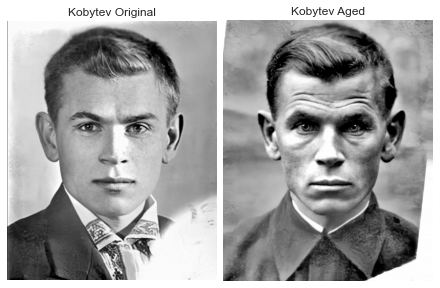

In [6]:

## Loading Images
img_1 = cv2.imread('inputs/P4/kobytev_1941.png', 0).astype(np.float32)
img_2 = cv2.imread('inputs/P4/kobytev_1945.png', 0).astype(np.float32)

before_after(img_1, img_2, name="Kobytev",effect_name="Aged")

In [7]:
print("Image 1 shape", img_1.shape)
print("Image 2 shape", img_2.shape)

Image 1 shape (956, 774)
Image 2 shape (956, 771)


In [8]:
img_2_temp = np.zeros_like(img_1)
img_2_temp[:img_2.shape[0], :img_2.shape[1]] = img_2
img_2 = img_2_temp

In [9]:
print("Image 1 shape", img_1.shape)
print("Image 2 shape", img_2.shape)

Image 1 shape (956, 774)
Image 2 shape (956, 774)


## Find Control Points

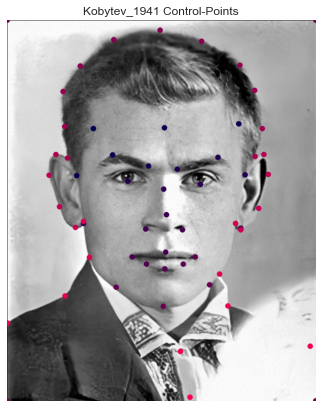

In [10]:
points_1 = np.zeros((59,2))

# region point coords
points_1[0, :] = [216, 272]
points_1[1, :] = [394, 270]
points_1[2, :] = [580, 260]
points_1[3, :] = [174, 390]
points_1[4, :] = [264, 338]
points_1[5, :] = [354, 366]
points_1[6, :] = [426, 374]
points_1[7, :] = [528, 344]
points_1[8, :] = [596, 388]
points_1[9, :] = [302, 404]
points_1[10, :] = [484, 412]
points_1[11, :] = [392, 424]
points_1[12, :] = [191, 510]
points_1[13, :] = [399, 488]
points_1[14, :] = [585, 522]
points_1[15, :] = [347, 524]
points_1[16, :] = [439, 526]
points_1[17, :] = [397, 582]
points_1[18, :] = [313, 594]
points_1[19, :] = [349, 612]
points_1[20, :] = [395, 624]
points_1[21, :] = [441, 612]
points_1[22, :] = [471, 594]
points_1[23, :] = [273, 670]
points_1[24, :] = [507, 664]
points_1[25, :] = [391, 718]

# Image Corners
points_1[26, :] = [0, 0]
points_1[27, :] = [0, img_1.shape[0]-1]
points_1[28, :] = [img_1.shape[1]-1, 0]
points_1[29, :] = [img_1.shape[1]-1, img_1.shape[0]-1]

# Face silhouette points
points_1[30+0, :] = [383, 25]
points_1[30+1, :] = [267, 49]
points_1[30+2, :] = [487, 53]
points_1[30+3, :] = [183, 115]
points_1[30+4, :] = [583, 113]
points_1[30+5, :] = [140, 179]
points_1[30+6, :] = [620, 176]
points_1[30+7, :] = [144, 267]
points_1[30+8, :] = [639, 272]
points_1[30+9, :] = [151, 346]
points_1[30+10, :] = [621, 342]
points_1[30+11, :] = [122, 337]
points_1[30+12, :] = [643, 337]
points_1[30+13, :] = [105, 389]
points_1[30+14, :] = [654, 387]
points_1[30+15, :] = [131, 468]
points_1[30+16, :] = [630, 472]
points_1[30+17, :] = [171, 520]
points_1[30+18, :] = [585, 526]
points_1[30+19, :] = [572, 510]
points_1[30+20, :] = [191, 505]
points_1[30+21, :] = [206, 595]
points_1[30+22, :] = [532, 637]
points_1[30+23, :] = [145, 692]
points_1[30+24, :] = [553, 717]
points_1[30+25, :] = [1, 760]
points_1[30+26, :] = [759, 818]
points_1[30+27, :] = [434, 831]
points_1[30+28, :] = [458, 946]

# endregion

debug_control_points(img_1, points_1, "Kobytev_1941")

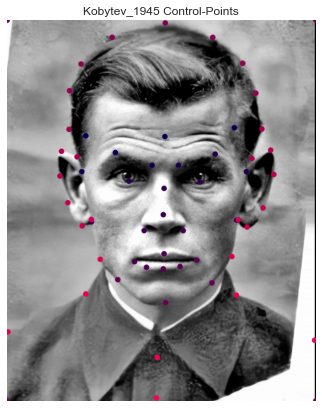

In [11]:
# Debug Control Points
points_2 = np.zeros((59,2))

# region point coords
points_2[0, :] = [197, 290]
points_2[1, :] = [395, 292]
points_2[2, :] = [569, 270]
points_2[3, :] = [187, 380]
points_2[4, :] = [271, 332]
points_2[5, :] = [363, 364]
points_2[6, :] = [429, 364]
points_2[7, :] = [521, 336]
points_2[8, :] = [599, 380]
points_2[9, :] = [305, 404]
points_2[10, :] = [483, 406]
points_2[11, :] = [393, 422]
points_2[12, :] = [211, 506]
points_2[13, :] = [391, 488]
points_2[14, :] = [575, 502]
points_2[15, :] = [343, 528]
points_2[16, :] = [441, 528]
points_2[17, :] = [393, 586]
points_2[18, :] = [319, 606]
points_2[19, :] = [349, 620]
points_2[20, :] = [391, 624]
points_2[21, :] = [433, 618]
points_2[22, :] = [475, 602]
points_2[23, :] = [277, 651]
points_2[24, :] = [513, 659]
points_2[25, :] = [397, 709]

# Image Corners
points_2[26, :] = [0, 0]
points_2[27, :] = [0, img_2.shape[0]-1]
points_2[28, :] = [img_2.shape[1]-1, 0]
points_2[29, :] = [img_2.shape[1]-1, img_2.shape[0]-1]

# Face silhouette points
points_2[30+0, :] = [396, 7]
points_2[30+1, :] = [263, 43]
points_2[30+2, :] = [515, 43]
points_2[30+3, :] = [185, 110]
points_2[30+4, :] = [590, 108]
points_2[30+5, :] = [156, 177]
points_2[30+6, :] = [623, 183]
points_2[30+7, :] = [155, 274]
points_2[30+8, :] = [638, 273]
points_2[30+9, :] = [175, 343]
points_2[30+10, :] = [613, 347]
points_2[30+11, :] = [136, 329]
points_2[30+12, :] = [660, 326]
points_2[30+13, :] = [132, 391]
points_2[30+14, :] = [668, 387]
points_2[30+15, :] = [152, 458]
points_2[30+16, :] = [641, 471]
points_2[30+17, :] = [188, 516]
points_2[30+18, :] = [601, 519]
points_2[30+19, :] = [579, 501]
points_2[30+20, :] = [211, 500]
points_2[30+21, :] = [233, 600]
points_2[30+22, :] = [563, 593]
points_2[30+23, :] = [197, 687]
points_2[30+24, :] = [574, 690]
points_2[30+25, :] = [2, 782]
points_2[30+26, :] = [770, 803]
points_2[30+27, :] = [376, 846]
points_2[30+28, :] = [374, 948]
# endregion

debug_control_points(img_2, points_2, "Kobytev_1945")


In [12]:
# Debugging control points index
# for j in range(len(points_1)):
#     print(j)
#     debug_control_points(img_1, points_1, "Kobytev_1941", only=j)
#     debug_control_points(img_2, points_2, "Kobytev_1945", only=j)
#     print("-"*30)

## Delunay Triangulation

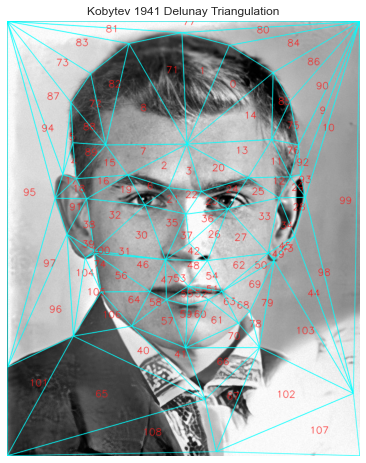

In [49]:
triangles_1, triangles_1_indices = debug_delunay(img_1, points_1, "Kobytev 1941")

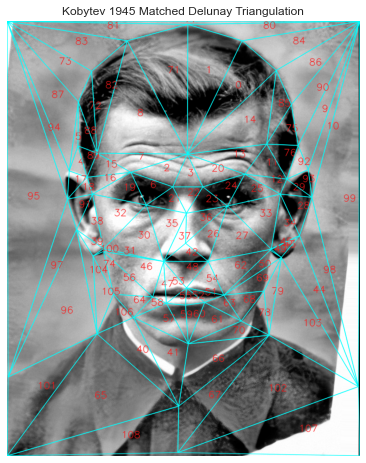

In [50]:
triangles_2 = debug_delunay(img_2, points_2, "Kobytev 1945", base_indices=triangles_1_indices)

## Find the intermediate control points

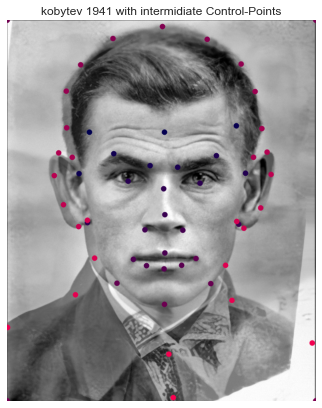

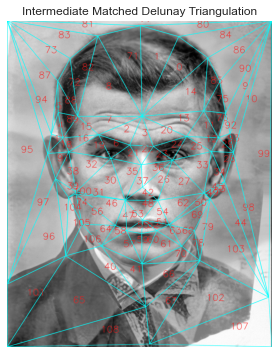

In [15]:
# Intermediate control-points
points_3 = (points_1 + points_2) / 2
img_3 = (img_1 + img_2) / 2
debug_control_points(img_3, points_3, name="kobytev 1941 with intermidiate")
subdiv_3 = debug_delunay(img_3, points_3, "Intermediate", base_indices=triangles_1_indices)

## Naiive Method Animation

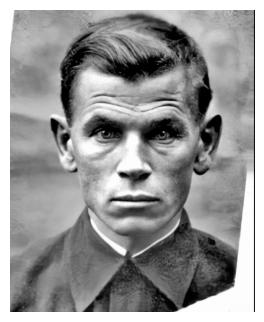

In [16]:
from matplotlib import animation

alpha = 1.0
naiive_blending = cv2.addWeighted(img_1, alpha, img_2, 1-alpha, 0)

NUM_FRAMES = 150

fig = plt.figure(dpi=100)
# ax = plt.axes(xlim=(0, 10), ylim=(0, 10))
plt.gca().set_axis_off()
im=plt.imshow(uint8ify(naiive_blending), cmap='gray')

# initialization function: plot the background of each frame
def init():
    im.set_data(naiive_blending)
    return [im]

# animation function.This is called sequentially
def animate(i):
    alpha = 1-(i/NUM_FRAMES)
    naiive_blending = cv2.addWeighted(img_1, alpha, img_2, 1-alpha, 0)

    im.set_array(uint8ify(naiive_blending))
    return [im]

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=NUM_FRAMES, blit=True)
anim.save('animation_naiive.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

plt.show()

In [17]:
def sort_triangles(triangles):
    triangle_centeroids = []
    tri_index = 0
    for t in triangles :

        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])
        centeroid = ((pt1[0]+pt2[0]+pt3[0])/3, (pt1[1]+pt2[1]+pt3[1])/3)

        # convert to int
        pt1 = tuple(map(int, list(pt1)))
        pt2 = tuple(map(int, list(pt2)))
        pt3 = tuple(map(int, list(pt3)))
        centeroid = tuple(map(int, list(centeroid)))

        triangle_centeroids.append((tri_index,centeroid))

        tri_index += 1

    triangle_centeroids = sorted(triangle_centeroids, key=lambda x: x[1][0])
    triangle_centeroids = sorted(triangle_centeroids, key=lambda x: x[1][1])
    
    new_triangles = []
    for i in range(len(triangles)):
        new_triangles.append(triangles[triangle_centeroids[i][0]])

    return np.array(new_triangles, dtype=np.float64)

In [18]:
# morph_images(img_1, img_2, subdiv_1, subdiv_2, alpha) ✅
#   get subdiv_3 using linear interpolation with alpha  ✅
#
#   for every triangle_1 in subdiv_1:✅
#       get affine transform between triangle_1 and correspoding triangle_3✅
#       find every pixel in triangle_1 ✅
#       for every on of those pixels:✅
#           apply the affine transformation to generate img_1_new✅
#
#   repeat for img_2
#
#   Now we have image_1_new✅ and image_2_new
#   linearly interpolate between image_1 and image_2 to get img_3
#   

In [19]:
from numba import jit

In [37]:
def morph_images(img_1, img_2, points_1, points_2, triangles_1_indices, triangles_1, triangles_2, alpha, show_mesh=False):
    # Intermediate control-points
    points_3 = (alpha)*points_1 + (1-alpha)*points_2

    # Intermediate control-points
    triangles_3 = debug_delunay(img_1, points_3, "Intermediate", base_indices=triangles_1_indices, draw=False)
    
    img_1_rgb = uint8ify(np.repeat(img_1[:, :, np.newaxis], 3, axis=2))
    img_2_rgb = uint8ify(np.repeat(img_2[:, :, np.newaxis], 3, axis=2))
    colors = [
    (255,0,0),   #rgb(255,0,0)
    (255,127,0), #rgb(255,127,0)
    (255,255,0), #rgb(255,255,0)
    (0,255,0),   #rgb(0,255,0)
    (0,255,127), #rgb(0,255,127)
    (0,255,255), #rgb(0,255,255)
    (0,0,255),   #rgb(0,0,255)
    ]






    # for every triangle in subdiv_1
    tri_index = 0
    img_1_new = np.zeros_like(img_1)
    for t1, t3 in zip(triangles_1, triangles_3) :
        # print(t1)
        triangle_pixel_mask = np.zeros_like(img_1)

        # Get triangle points
        pt1_1 = (t1[0], t1[1])
        pt2_1 = (t1[2], t1[3])
        pt3_1 = (t1[4], t1[5])

        pt1_3 = (t3[0], t3[1])
        pt2_3 = (t3[2], t3[3])
        pt3_3 = (t3[4], t3[5])

        # convert to int(required)
        pt1_1 = tuple(map(int, list(pt1_1)))
        pt2_1 = tuple(map(int, list(pt2_1)))
        pt3_1 = tuple(map(int, list(pt3_1)))

        pt1_3 = tuple(map(int, list(pt1_3)))
        pt2_3 = tuple(map(int, list(pt2_3)))
        pt3_3 = tuple(map(int, list(pt3_3)))

        points_1 = np.array([pt1_1, pt2_1, pt3_1])
        points_3 = np.array([pt1_3, pt2_3, pt3_3])
        
        if show_mesh:
            cv2.fillPoly(img_1_rgb, [points_3], color=colors[tri_index%len(colors)])
        cv2.fillPoly(triangle_pixel_mask, [points_1], color=255)
        # disp(triangle_pixel_mask.astype(np.uint8))
        
        if show_mesh == False:
            # Get affine transformation matrix for the triangle
            M_1 = cv2.getAffineTransform(points_1.astype(np.float32), points_3.astype(np.float32))

            # Apply affine transformation to both the img and the current triangle mask
            img_1_warped = cv2.warpAffine(img_1, M_1, (img_1.shape[1], img_1.shape[0]))
            triangle_pixel_mask_warped = cv2.warpAffine(triangle_pixel_mask, M_1, (img_1.shape[1], img_1.shape[0]))

            # Update the portion of the result that lies within the current triangle
            img_1_new[triangle_pixel_mask_warped>0] = img_1_warped[triangle_pixel_mask_warped>0]
        
        tri_index += 1
    # disp(img_1_rgb)


    if show_mesh:
        return img_1_rgb





    # for every triangle in subdiv_2
    tri_index = 0
    img_2_new = np.zeros_like(img_2)
    for t2, t3 in zip(triangles_2, triangles_3) :
        # print(t1)
        triangle_pixel_mask = np.zeros_like(img_2)

        # Get triangle points
        pt1_2 = (t2[0], t2[1])
        pt2_2 = (t2[2], t2[3])
        pt3_2 = (t2[4], t2[5])

        pt1_3 = (t3[0], t3[1])
        pt2_3 = (t3[2], t3[3])
        pt3_3 = (t3[4], t3[5])

        # convert to int(required)
        pt1_2 = tuple(map(int, list(pt1_2)))
        pt2_2 = tuple(map(int, list(pt2_2)))
        pt3_2 = tuple(map(int, list(pt3_2)))

        pt1_3 = tuple(map(int, list(pt1_3)))
        pt2_3 = tuple(map(int, list(pt2_3)))
        pt3_3 = tuple(map(int, list(pt3_3)))

        points_2 = np.array([pt1_2, pt2_2, pt3_2])
        points_3 = np.array([pt1_3, pt2_3, pt3_3])
        
        cv2.fillPoly(img_2_rgb, [points_2], color=colors[tri_index%len(colors)])
        cv2.fillPoly(triangle_pixel_mask, [points_2], color=255)
        # disp(triangle_pixel_mask.astype(np.uint8))
        
        # Get affine transformation matrix for the triangle
        M_2 = cv2.getAffineTransform(points_2.astype(np.float32), points_3.astype(np.float32))

        # Apply affine transformation to both the img and the current triangle mask
        img_2_warped = cv2.warpAffine(img_2, M_2, (img_2.shape[1], img_2.shape[0]))
        triangle_pixel_mask_warped = cv2.warpAffine(triangle_pixel_mask, M_2, (img_2.shape[1], img_2.shape[0]))

        # Update the portion of the result that lies within the current triangle
        img_2_new[triangle_pixel_mask_warped>0] = img_2_warped[triangle_pixel_mask_warped>0]
        
        tri_index += 1
    # disp(img_2_rgb)

    





    return (alpha)*img_1_new + (1-alpha)*img_2_new


In [28]:
%%time
result = morph_images(img_1, img_2, points_1, points_2, triangles_1_indices, triangles_1, triangles_2, alpha=0.0)
# disp(result)

CPU times: total: 9.23 s
Wall time: 1.95 s


In [55]:
%%time
result = morph_images(img_1, img_2, points_1, points_2, triangles_1_indices, triangles_1, triangles_2, alpha=0.0, show_mesh=True)
# disp(result)

CPU times: total: 312 ms
Wall time: 306 ms


## Generate Morph animation using delunay triangulation

Takes about 6 minutes to complete

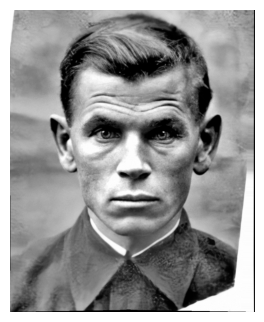

In [22]:
from matplotlib import animation

alpha = 1.0
result = morph_images(img_1, img_2, points_1, points_2, triangles_1_indices, triangles_1, triangles_2, alpha=alpha)

NUM_FRAMES = 150

fig = plt.figure(dpi=100)
# ax = plt.axes(xlim=(0, 10), ylim=(0, 10))
plt.gca().set_axis_off()
im=plt.imshow(uint8ify(result), cmap='gray')

# initialization function: plot the background of each frame
def init():
    im.set_data(result)
    return [im]

# animation function.This is called sequentially
def animate(i):
    alpha = 1-(i/NUM_FRAMES)
    result = morph_images(img_1, img_2, points_1, points_2, triangles_1_indices, triangles_1, triangles_2, alpha=alpha)
    im.set_array(uint8ify(result))
    return [im]

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=NUM_FRAMES, blit=True)
anim.save('animation_better.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

plt.show()

## Generate Mesh animation

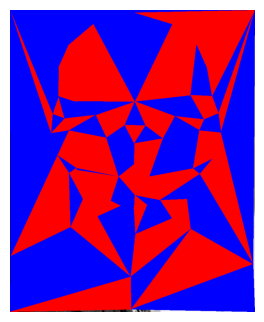

In [36]:
from matplotlib import animation

alpha = 1.0
result = morph_images(img_1, img_2, points_1, points_2, triangles_1_indices, triangles_1, triangles_2, alpha=alpha, show_mesh=True)

NUM_FRAMES = 150

fig = plt.figure(dpi=100)
# ax = plt.axes(xlim=(0, 10), ylim=(0, 10))
plt.gca().set_axis_off()
im=plt.imshow(result, cmap='gray')

# initialization function: plot the background of each frame
def init():
    im.set_data(result)
    return [im]

# animation function.This is called sequentially
def animate(i):
    alpha = 1-(i/NUM_FRAMES)
    result = morph_images(img_1, img_2, points_1, points_2, triangles_1_indices, triangles_1, triangles_2, alpha=alpha, show_mesh=True)
    im.set_array(result)
    return [im]

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=NUM_FRAMES, blit=True)
anim.save('mesh_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

plt.show()